In [49]:

#Loading packages and functions

#Python 3.10.13 was used to run this example

#pandas ver 1.4.2
import pandas as pd
#pyBigWig ver 0.3.22
import pyBigWig 
#matplotlib ver 3.7.1
import matplotlib.pyplot as plt
#seaborn ver 0.11.2
import seaborn as sns
#geoparse ver 2.0.4
import GEOparse
#wget ver 1.21.4
import wget

import glob


#remove ENCODE blacklist regions - bias high signal regions that are problematic in ChIP experiments
def bl(t,b): 
    bl=pd.read_table('data/'+b,header=None)
    bl['r']=bl.apply(lambda x: set(range(x[1],x[2])),axis=1)
    bg=bl.groupby(0)['r'].apply(list)
    bg=bg.apply(lambda x:set.union(*x))   
    t['r']=t.apply(lambda x: set(range(x[1],x[2])),axis=1)
    t['bl']=t.apply(lambda x: len(x['r'].intersection(bg[x['ch']])),axis=1)
    t=t[t['bl']==0].drop('r',axis=1)
    return t

#plotting total methylation per sample 
def pwg(cells,folder,x,chrs=22,color=[],w=.9,ylabel='DNAm',figure='f'): 
    bs=[]
    for cell in cells:
        print(cell,end=',')
        #bw=pyBigWig.open('data/'+folder+cell+'.bw')
        bw = pyBigWig.open(next(iter(glob.glob('data/' + folder + '*/*' + cell + '.bw'))))
        bsc=[]
        for ch in range(1,chrs+1):
            bsc.append(bw.stats('chr'+str(ch),0,-1)[0])
        bs.append(bsc)
    bs=pd.DataFrame(bs)
    pl=pd.DataFrame(bs.mean(1))
    pl[x]=cells
    fig, ax = plt.subplots(figsize=(w,2));
    ax=sns.barplot(data=pl,x=x,y=0);
    ax.set(ylabel=ylabel,title='All CpGs');
    plt.xticks(rotation=90,fontsize=8); 
    fig.savefig('figures/'+figure+'.png', dpi=600,bbox_inches='tight')
    return bs

#PRC2 AgeIndex plot - plotting percentage methylation (rolling average) against LMRs sorted by PRC2 binding 
def pprc(tp,color=[],title='DNAm at LMRs',r=10**5,w=3,ylabel='DNAm',figure='f'):
    ax=tp.rolling(r).mean().dropna().plot(figsize=(w,2))    
    ax.get_legend().remove()
    ax.set_xticks([])
    ax.set_xlabel('LMRs ranked by PRC2 binding', fontsize=10)
    ax.set(ylabel=ylabel,title=title);
    ax.get_figure().savefig('figures/'+figure+'.png', dpi=600,bbox_inches='tight')
    plt.show()
    
#Zoomed in plot of right hand side of PRC2 AgeIndex Plot
def pprch(tp,n,m,color=None,labels=[],legend_title='years',figure='f',title=''):
    dg=tp.tail(round(10**n)).rolling(round(10**m)).mean().dropna()
    ax=dg.plot(figsize=(1.2,2),color=color)
    labels=tp.columns
    handles, labels = ax.get_legend_handles_labels()    
    ax.legend(handles[::-1], labels[::-1],title=legend_title,loc='center left', bbox_to_anchor=(1, 0.5))    
    ax.set_xticks([])
    ax.set_xlabel('PRC2 binding', fontsize=10)  
    ax.set_title('DNAm at High-PRC2 LMRs')    
    ax.get_figure().savefig('figures/'+figure+'.png', dpi=600,bbox_inches='tight')
    return dg    

#Further zoom of right hand side of PRC2 AgeIndex Plot
def pprchz(tp,n,m,color=None,labels=[],legend_title='years',figure='f',title=''):
    dg=tp.tail(round(9**n)).rolling(round(10**m)).mean().dropna()
    ax=dg.plot(figsize=(1.2,2),color=color)
    if len(labels)==0: 
        labels=tp.columns
        handles, labels = ax.get_legend_handles_labels()    
        ax.legend(handles[::-1], labels[::-1],title=legend_title,loc='center left', bbox_to_anchor=(1, 0.5))    
    else:
        handles, l = ax.get_legend_handles_labels()    
        ax.legend([handles[-1],handles[0]], [labels[-1],labels[0]],title=legend_title,loc='center left', bbox_to_anchor=(1, 0.5))    
    ax.set_xticks([])
    ax.set_xlabel('PRC2 binding', fontsize=10)  
    ax.set_title('DNAm at High-PRC2 LMRs')    
    ax.get_figure().savefig('figures/'+figure+'.png', dpi=600,bbox_inches='tight')
    return dg

In [40]:
%%time
#Downloading methylation bigwig files for Neonatal (can substitute for bigwig methylation files of your own desired cell type/samples, however, low methylated regions (hmr file) may have to calculated separetly for you desired cell type)

geo_accession = "GSE253985"
gse = GEOparse.get_GEO(geo=geo_accession, destdir="./data/meth/NeoFib")
gse.download_supplementary_files(directory='./data/meth/NeoFib', 
                                 download_sra=False, 
                                 email=None, sra_kwargs=None, nproc=1)

21-Jun-2024 10:44:01 DEBUG utils - Directory ./data/meth/NeoFib already exists. Skipping.
21-Jun-2024 10:44:01 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE253nnn/GSE253985/soft/GSE253985_family.soft.gz to ./data/meth/NeoFib/GSE253985_family.soft.gz
100%|██████████| 3.07k/3.07k [00:00<00:00, 9.59kB/s]
21-Jun-2024 10:44:01 DEBUG downloader - Size validation passed
21-Jun-2024 10:44:01 DEBUG downloader - Moving /var/folders/vc/_r7tgfkn3gxfg9s69xwg97zw0000gr/T/tmpb_z53ujk to /Users/dsimps93/PRC2_Index_MSver_Clean/PRC2AgeIndex_User_Friendly_Example/data/meth/NeoFib/GSE253985_family.soft.gz
21-Jun-2024 10:44:01 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE253nnn/GSE253985/soft/GSE253985_family.soft.gz
21-Jun-2024 10:44:01 INFO GEOparse - Parsing ./data/meth/NeoFib/GSE253985_family.soft.gz: 
21-Jun-2024 10:44:01 DEBUG GEOparse - DATABASE: GeoMiame
21-Jun-2024 10:44:01 DEBUG GEOparse - SERIES: GSE253985
21-Jun-2024 10:44:01 DEBUG 

CPU times: user 5.59 s, sys: 9.09 s, total: 14.7 s
Wall time: 7min 40s


{'GSM8031497': {'ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM8031nnn/GSM8031497/suppl/GSM8031497_NEO2_P2_meth.bw': '/Users/dsimps93/PRC2_Index_MSver_Clean/PRC2AgeIndex_User_Friendly_Example/data/meth/NeoFib/Supp_GSM8031497_NEO_Biological_Rep_2__Passage_2/GSM8031497_NEO2_P2_meth.bw'},
 'GSM8031498': {'ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM8031nnn/GSM8031498/suppl/GSM8031498_NEO2_P5_meth.bw': '/Users/dsimps93/PRC2_Index_MSver_Clean/PRC2AgeIndex_User_Friendly_Example/data/meth/NeoFib/Supp_GSM8031498_NEO_Biological_Rep_2__Passage_5/GSM8031498_NEO2_P5_meth.bw'},
 'GSM8031499': {'ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM8031nnn/GSM8031499/suppl/GSM8031499_NEO2_P8_meth.bw': '/Users/dsimps93/PRC2_Index_MSver_Clean/PRC2AgeIndex_User_Friendly_Example/data/meth/NeoFib/Supp_GSM8031499_NEO_Biological_Rep_2__Passage_8/GSM8031499_NEO2_P8_meth.bw'},
 'GSM8031500': {'ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM8031nnn/GSM8031500/suppl/GSM8031500_OLD3_P2_meth.bw': '/Users/dsimps93/PRC2_Index_MSver_Clea

In [9]:
%%time
#Downloading embryonic PRC2 ChIP files used for LMR sorting
wget.download("https://www.encodeproject.org/files/ENCFF105JFX/@@download/ENCFF105JFX.bigWig", out="./data/chip/")
wget.download("https://www.encodeproject.org/files/ENCFF224RZW/@@download/ENCFF224RZW.bigWig", out="./data/chip/")

'./data/chip//ENCFF224RZW.bigWig'

In [44]:
%%time

# Getting mean methylation per LMR 

folder='meth/NeoFib/';cell='NEO2_allPs' #data/meth/NeoFib/ contains all meth bw files needed to calculate mean methylation per LMR. 
#NEO2_allPs refers to the .hmr (list of LMRs) file. 

#User can substitute with another hmr file to calculate for other cell types, for example, t cell, the hmr file of which is provided
#folder='meth/t/';cell='t' # user should switch to this if inputting t-cell methylation bw files

#load and download the following ChIP fold change (IP/input) files from ENCODE
ez=pyBigWig.open('data/chip/ENCFF105JFX.bigWig') # EZH2 esc fold change - download to data/chip folder from https://www.encodeproject.org/files/ENCFF105JFX/
su=pyBigWig.open('data/chip/ENCFF224RZW.bigWig') # SUZ12 esc fold change - download to data/chip folder from https://www.encodeproject.org/files/ENCFF224RZW/

# s1. get ezh2 binding within LMRs
t=pd.read_csv('data/'+folder+cell+'.hmr',sep='\t',header=None,usecols=[0,1,2,4])
t=t[~t[0].isin(['chrX','chrY','chrM','chrMT','MT','X','Y','M'])].copy() #remove non-autosomal chromosomes
t.columns=['ch','b','e','d'] #apply column names (ch = "chromosome", b = "beginning", e = "end", d = "number of CpGs in given LMR")

t['ez']=t.apply(lambda x:ez.stats(x[0],x[1],x[2])[0],axis=1) #find EZH2 binding for each LMR
t['su']=t.apply(lambda x:su.stats(x[0],x[1],x[2])[0],axis=1) #find SUZ12 binding for each LMR
t['pr']=t[['ez','su']].mean(1) #take mean of EZH2 and SUZ12 binding for each LMR

print(len(t)) #Print number of LMRs
t=bl(t,'hg38-blacklist.v2.bed.gz') # loading blacklisted regions downloaded from https://github.com/Boyle-Lab/Blacklist/tree/master

#s2. get DNAm within LMRs for each sample 
cells=["NEO2_P2_meth","NEO2_P5_meth","NEO2_P8_meth"] #change to filenames of samples
for cell in cells:
    bs=[]
    print(cell,end=',')
    bw = pyBigWig.open(next(iter(glob.glob('data/' + folder + '*/*' + cell + '.bw'))))
    #bw=pyBigWig.open('data/'+folder+cell+'.bw')
    for i,r in t.iterrows():
        if (i % 1000) == 0:print('.',end='')
        bs.append(bw.stats(r['ch'],r['b'],r['e'])[0])
    print()
    t[cell]=bs
t=t.dropna().copy().round(3)


#save methylation values and sort by EZH2 and SUZ12 binding
dft=t.sort_values('pr').reset_index()

#save so you don't need to produce everytime
dft.to_csv('data/meth/NeoFib/NEOP2s_methBWs_hESCord_FE.csv') 

80176
NEO2_P2_meth,..............................................................................
NEO2_P5_meth,..............................................................................
NEO2_P8_meth,..............................................................................
CPU times: user 2min 15s, sys: 29.5 s, total: 2min 45s
Wall time: 2min 46s


NEO2_P2_meth,NEO2_P5_meth,NEO2_P8_meth,

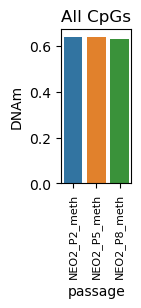

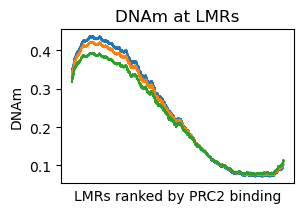

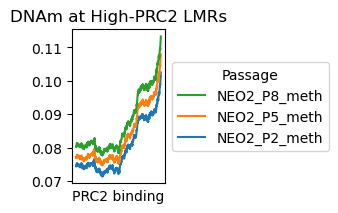

In [50]:
#Read in PRC2 sorted methylation file from previous step (skip to this step if this file has already been computed)
dft= pd.read_csv('data/meth/NeoFib/NEOP2s_methBWs_hESCord_FE.csv',index_col=0) 

cells=["NEO2_P2_meth","NEO2_P5_meth","NEO2_P8_meth"]
c0=cells[0]
l=dft.apply(lambda x:int(x['d'])*[x[c0]],axis=1)
l=[item for sublist in l for item in sublist]
df=pd.DataFrame(l)
df.columns=[c0]
for cell in cells[1:]:
    l=dft.apply(lambda x:int(x['d'])*[x[cell]],axis=1)
    l=[item for sublist in l for item in sublist]
    df[cell]=l
    
#plots
pl=pwg(cells,folder,'passage',figure='NEOfibros_totalMeth') #plots total methylation of each sample
dg=pprc(df,figure='Fig6b_Neos') #plot all LMRs sorted by EZH2 binding

dg=pprchz(df,6,5,legend_title='Passage',figure='Fig6b_Neos_zoom2') #zoomed in on top PRC2 binding LMRs